# Structured and time series data

* [Notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb)
* [video ML11](https://youtu.be/9C06ZPF8Uuc?t=2h2m42s)
* [Video ML12](https://www.youtube.com/watch?v=5_xFdhfUnvQ&feature=youtu.be)
* [Notes DL3](https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-3-74b0ef79e56)
* [Notes DL4](https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-4-2048a26d58aa)
* [Kaggle Competition](https://www.kaggle.com/c/rossmann-store-sales)

## Rossman Competition details:
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. 
Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. 
With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
<br>
In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. 
Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. 
By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! 

## Solution
This notebook contains an implementation of the 3rd place result in the Rossmann Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).
<br>
The motivation behind exploring this architecture is it's relevance to real-world applications. 
Most data used for decision making in industry is structured and/or time-series data. 
Here we explore the end-to-end process of using ANNs with practical structured data problems.

In [1]:
#%pwd
import torch
print("Pytorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time
t0 = time.clock()
time.ctime(time.time())

Pytorch version: 0.4.0


'Wed Jul 18 10:55:43 2018'

## Preliminaries

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
PATH='/data/rossmann/'

import numpy as np
import pandas as pd

In [3]:
np.set_printoptions(threshold=50, # Total number of array elements which trigger summarization rather than full repr (default 1000).
                    edgeitems=20) # Number of array items in summary at beginning and end of each dimension (default 3)

## Create datasets

In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. You can download all of them [here](http://files.fast.ai/part2/lesson14/rossmann.tgz).

For completeness, the implementation used to put them together is included below.

In [4]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob.glob(f"{path}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")   #Notice this at end of file

NB: Files must finish by "\n", else some of the conversions fail...

### Feature Space:
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* state_names: List of German state names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather
* test: testing set

In [5]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

`pandas` allows to manipulate tables/data frames in python as one would in a DB.<br>
using `pd.read_csv` to load the above (7) (`fname`).csv files as dataframes into the list `tables`.
<br>
`low_memory` : Internally process the file in chunks, resulting in lower memory use while parsing, 
but possibly mixed type inference.          

In [6]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False)  
          for fname in table_names]

### Missing index in Kaggle table 
test table (v2 from Kaggle) is missing Index which we need for skipping validation set. Add it now. (Or later?)

In [7]:
t = tables[6]
t['Id'] = t.index + 1

In [8]:
from IPython.display import HTML

### Quick look at the contents of each table:

Use `head()` to get a quick look at the contents of each table:
* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holliday, etc.
* store: general info about the store including competition, etc.
* store_states: maps store to state it is in
* state_names: Maps state abbreviations to names
* googletrend: trend data for particular week/state
* weather: weather conditions for each state
* test: Same as training table, w/o sales and customers


In [9]:
i = 0
for t in tables: 
    print("\nDF:", table_names[i]); i += 1 
    display(t.head(3))


DF: train


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1



DF: store


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"



DF: store_states


,Store,State
0,1,HE
1,2,TH
2,3,NW



DF: state_names


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE



DF: googletrend


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91



DF: weather


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240



DF: test


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0


This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

### summary of each DF using `display(DataFrameSummary(t).summary())`

NB: Below was giving:<br>
AttributeError: module 'pandas.core.common' has no attribute 'is_numeric_dtype'
<br>
was fixed by downgrading pandas_summary

In [10]:
from pandas_summary import DataFrameSummary
for t in tables: display(DataFrameSummary(t).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


,StateName,State
count,16,16
unique,16,16
top,Saarland,BW
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,...,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,...,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,...,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,...,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,...,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,...,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,...,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,...,24,32,24,44,29,47,41,9,21,362


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


# Data Cleaning / Feature Engineering

As a structured data problem, we have to go through all the cleaning and feature engineering, even though we're using an ANN.

In [11]:
train, store, store_states, state_names, googletrend, weather, test = tables
print("Training set=", len(train), "Test set =", len(test)) #, len(store), len(store_states), len(state_names), len(googletrend), len(weather)

Training set= 1017209 Test set = 41088


### Turn State Holidays to Boolean
We turn state Holidays to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [12]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

### Join Tables

`join_df` joins tables on specific fields. <br>
By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.
<br>
Pandas does joins using the `merge` method. 
The `suffixes` argument describes the naming convention for duplicate fields. 
We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.

In [13]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))   # if the 2 columns have the same then suffix is nothing ""

Join weather/state names.

In [14]:
weather = join_df(weather, state_names, "file", "StateName")
weather.head(2) 

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,State
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,NW
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,10.0,24,16,NaN,0.00,6.0,Rain,225,NordrheinWestfalen,NW


In [15]:
googletrend.head(2)

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95


In pandas we add new columns to a `dataframe` by simply defining them. 
We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

pandas gives us access to all of Python. 
For example, inside the series object, the `str` attribute gives us access to
all the string processing functions.
(like cat gives access to the categorical functions, and DT gives access to the date/time functions).
We can now split everything in that column.
These pandas functions are vectorized and accelerated.  

In [16]:
#Add Date and State columns to this DF
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.head(1)

,file,week,trend,Date,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN


### Pandas indexing
We replace all instances of the state name `NI` (Niedersachsen aka Lower Saxony) to match the usage in the rest of the data: `HB,NI`. 
(HB is Bremen, a free city "inside" Niedersachsen). <br>
We use pandas indexing, `.loc[rows, cols]` to select a list of rows and a list of columns from the dataframe. 
In this case, we're selecting rows w/ statename `NI` by using a boolean list `googletrend.State=='NI'` and selecting `"State"`.

In [17]:
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

### Using `add_datepart()` to extract particular date fields (from a complete datetime) for constructing categoricals.

NB: **Always** consider this feature extraction step when working with date-time. 
Without expanding date-time into these additional fields, we can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

In [18]:
from fastai.structured import add_datepart

`add_datepart` converts a column of `df` from a `datetime64` 
to many columns containingthe information from the date. 
This applies changes inplace.

- `df`: A pandas data frame. df gain several new columns.
- `fldname`: A string that is the name of the date column you wish to expand.
    If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
- `drop`: If true then the original date column will be removed.
- `time`: If true time features: Hour, Minute, Second will be added.

In [19]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

Take a date and pull out a bunch of columns such as “day of week”, “start of a quarter”, “month of year” and so on and add them all to the dataset. <br>
Duration section will calculate things like how long until the next holiday, how long it has been since the last holiday, etc.

#### The Googletrend data has a special category for the whole of the Germany - we'll pull that out so we can use it explicitly.

In [20]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

### Now outer join all of our data into a single dataframe. 

In outer joins, everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. 
<br>
NB: To verify that all records are consistent and complete. we check for `Null` values post-join, e.g.,  `len(store[store.State.isnull()])`. Similarly for the other joins below.

#### *Aside*: Why note just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, if you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [21]:
#Create a DF for the Stores
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

Now join the dataframes with the `store` df

In [22]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]), len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

Now join the googletrend dataframe

In [23]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]), len(joined_test[joined_test.trend.isnull()])

(0, 0)

For the merge function we set in `join_df` the suffix:
if there are 2 columns are the same we set their suffix on the left to be `""` (nothing)
so it doesn't screw around with the name and the right hand the suffix is `_y`

In [24]:
#Use MERGE for the trend_de ... WHY merge here?
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]), len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [25]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

#### Drop the _y columns in both DFs

We didn't want any of the duplicate ones, so below we delete them.

In [26]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

### Fill in missing values to avoid complications with `NA`'s. 

Below we will create durations (eg `openSince`). So we need to ensure that there are no missing values, else we will get errors.
Pandas uses `NA` (Not Available) to indicate missing values; <br>
Many models have problems when missing values are present, so it's important to think how to deal with them. 
In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.  
For example, for Year, the fill for `NA` is `1900`, while for `Month` and `Week` we choose `1`.

In [27]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

### Extract features `CompetitionOpenSince` and `CompetitionDaysOpen`. 
Note the use of `apply()` in mapping a function across dataframe values.  
What we really want to know is how long has this store been open (in days, i.e. `"CompetitionDaysOpen"`) 
for this particular record. so we use `Date.substract`

In [28]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

### replace erroneous / outlying data 
For example, sometimes the competition opened later, after the store, i.e., negative days open.
It probably does not make sense to have negative.
Because assumptions about the data often turned out not to be true,
JH would never put in something like (below) without first running a model with it in and without it in.
<br> 
In this case JH believes that the 3rd-place winners validated that setting the negatives to zero improved their score.

In [29]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

### Limit the number of unique categories by adding fields
As we create a NN, some of the inputs are continuous, and some are categorical.
The categorical values are stored as indeces (not 1-hot encoded). <br>
The ANN needs to know for which of the columns to create an embedding,
i.e., to treat them as-if they were 1-hot encoded.

Also, for categorical, we don't want to create more categories than we need.

#### We add "CompetitionMonthsOpen" field
limiting the maximum to 2 years (24 months) to limit the number of unique categories.
(They could have done this as a continuous variable, but it is better, when possible, to use categorical variables)
When we feed something through an embedding matrix, every level can be treated differently.
In this case, weather the competition is open 0 or 1 months is quite different.
If it was a continuous variable, it would be more difficult for the ANN 
to find a functional form that has that big difference.
An ANN could do it, but it will be harder with a continuous than with an embedding as categorical.
If we have enough data, treating columns as categorical variables where possible (cardinalities not too high so embedding matrix is not too big), is better.

In [30]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

Above are all the unique categories, which are all the numbers from 0 to 24.

#### Same process for Promo dates.

Notice below that the `df.apply lambda` is **very slow** as it repeatedly invokes a Python function to a column. 
JH used this because he was unable to find a function that would (vectorized) compute (pandas or numpy) for year and week number into a date...
`lambda` is creating a function just for this single use.
Alternatively, we could have written `create_promo2since` and pass it by name:
```
def create_promo2since(x):
    return Week(x.Promo2SinceYear, x.Promo2SinceWeek).monday() 
```
and invoke it as
```
df.apply(create_promo2since, axis=1)
```

In [31]:
from isoweek import Week

In [32]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [33]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

### Save data -
`joined` is the training set, `joined_test` is the test set

In [34]:
import feather    # fast saving/loading of dataframes 

In [35]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')
print("Size of training set=", len(joined), "Size of test set=", len(joined_test))

Size of training set= 1017209 Size of test set= 41088


Saves a Pandas’ data frame into a “feather” format which takes it as it sits in RAM and dumps it to the disk fast. 
Ecuadorian grocery competition has 350 million records, so we care about how long it takes to save.

## Durations
We are going to look at 3 fields, `Promo`, `StateHoliday`, `SchoolHoliday`:
a table for each store for each date, that store have a promo going on, it is a school and/or is there a state holiday.

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. 
Thus, we've created a class to handle this type of data.
<br>
We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. 
Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. 
When the field is seen again, the counter is set to zero.  
Hence, for a given store and a given event (eg `StateHoliday`) we will be able to know 
how long before the last one and how long until the next one. 
So we create 2 new columns for each such event.  
No known library for this, so JH implemented `get_elapsed` below.
<br>
Upon initialization, this will result in datetime `NA`'s until the field is encountered. 
This is reset every time a new store is seen. We'll use it below.

In [36]:
def get_elapsed(sdf, fld, pre):   # GSG: Added sdf as sorted df parameter
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()  # arbitrary last date?
    last_store = 0
    res = []

    for s,v,d in zip(sdf.Store.values, sdf[fld].values, sdf.Date.values):
        if s != last_store:  # when it is a new store, we need to reset.
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d   # if it was a school holiday keep track of it
        ra = ((d-last_date).astype('timedelta64[D]') / day1).astype(int)
        if ra < 0: ra = 0  # GSG: Added check to avoid negative durations
        res.append(ra)       #.astype(int))
    sdf[pre+fld] = res
    return sdf

Above notice the use of zip with 3 np.arrays (Store, `fld`, and date). 
Alternative way would have been to write:
```
for row in df.iterrows():
```
but this would iterate on a DF, which is **very slow**,  ie 300 times slower.
It is much faster to iterate over np.arrays.
zip means loop thru each of the list one at a time, and grab them.
Above it is a loop over every store, every school holiday, and every date.
Very common pattern to loop thru a list and grab elements.

We'll be applying this (get_elapsed) to a subset of columns:

In [37]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

Below JH used the same variable, df, instead of 2 different variables....
That prevented the running of the notebook from begining to end, as it was 
requiring running all the following twice, once for train and once for test. 

In [38]:
df_train = train[columns].copy()   #DF for the above train columns to df_train
df_test = test[columns].copy()      #DF for the test set 

Let's walk through an example.
<br>
Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

In [39]:
def add_before_after_count (df1, fld):
    df1 = df1.sort_values(['Store', 'Date'])  #Sort by Store, then Date
    df1 = get_elapsed(df1, fld, 'After')
    df1 = df1.sort_values(['Store', 'Date'], ascending=[True, False])
    df1 = get_elapsed(df1, fld, 'Before')
    return df1

Compute Before and After for SchoolHoliday, StateHoliday, and Promo, for both train and test set.

In [40]:
columnsBaA = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [41]:
for col in columnsBaA:
    df_train = add_before_after_count(df_train, col)
    df_test = add_before_after_count(df_test, col)
#df_train.head(1)

## Set the active index to Date.

In [42]:
df_train = df_train.set_index("Date")
df_test = df_test.set_index("Date")

#### Then set null values from elapsed field calculations to 0.

In [43]:
for dfx in [df_train, df_test]:
    for o in ['Before', 'After']:
        for p in columnsBaA:
            a = o+p
            dfx[a] = dfx[a].fillna(0)

### Demonstrate window functions in pandas to calculate rolling quantities.
We will like to evaluate moving functions, ie moving average is a window function, eg the average sales over a 7 day period.
pandas Provides rolling window calculations with [`rolling`](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.Series.rolling.html).
```
Series.rolling(window, min_periods=None, center=False, win_type=None, on=None, axis=0, closed=None)[source]

```
See the pandas [Time Series / Date functionality](https://pandas.pydata.org/pandas-docs/stable/timeseries.html),
there is a lot. pandas original was originally focused on time-series.
<br>
**TODO:** Learn this API

#### First we do it for the `train` df 

In [44]:
df_train.head(3)

,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo
Date,,,,,,,,,,
2015-07-31,1,1,False,1,0,0,57,0,0,0
2015-07-30,1,1,False,1,0,0,56,0,0,0
2015-07-29,1,1,False,1,0,0,55,0,0,0


Below is the weekly, by store sums. 
Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) 
defined in columns in the following week (`rolling()`), grouped by Store (`groupby()`). 
<br>
We do the same in the opposite direction.

In [45]:
bwd = df_train[['Store']+columnsBaA].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
fwd = df_train[['Store']+columnsBaA].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()

Next we want to drop the `Store` indices grouped together in the window function.
<br>
Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [46]:
for dfx in [bwd, fwd]:
    dfx.drop('Store',1,inplace=True)  #Drop the Store indiced grouped together
    dfx.reset_index(inplace=True)

In [47]:
df_train.reset_index(inplace=True)
#df_train.head(1)

Now we'll merge these values onto the `df_train`.

In [48]:
df_train = df_train.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_train = df_train.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])
df_train.drop(columnsBaA,1,inplace=True)
df_train.head(3)

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-07-31,1,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2015-07-30,1,0,0,56,0,0,0,4.0,0.0,4.0,2.0,0.0,2.0
2,2015-07-29,1,0,0,55,0,0,0,3.0,0.0,3.0,3.0,0.0,3.0


#### Now lets do it for the test df

In [49]:
df_test.head(3)

,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo
Date,,,,,,,,,,
2015-09-17,1,1,False,0,13,0,0,0,0,0
2015-09-16,1,1,False,0,12,0,0,0,0,0
2015-09-15,1,1,False,0,11,0,0,0,0,0


In [50]:
bwd = df_test[['Store']+columnsBaA].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
fwd = df_test[['Store']+columnsBaA].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()

Drop the Store indices grouped together in the window function.

In [51]:
for dfx in [bwd, fwd]:
    dfx.drop('Store',1,inplace=True)  #Drop the Store indiced grouped together
    dfx.reset_index(inplace=True)

df_test.reset_index(inplace=True)

In [52]:
df_test = df_test.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_test = df_test.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])
df_test.drop(columnsBaA,1,inplace=True)
df_test.head(3)

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,0,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,0,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,0,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0


In [53]:
display(DataFrameSummary(df_train).summary())

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
count,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06
mean,NaN,558.43,23.3568,0,36.907,0,3.22143,0,1.23277,0.213673,2.64868,1.23098,0.206798,2.6706
std,NaN,321.909,22.0293,0,31.1821,0,5.91011,0,2.05389,0.475514,1.91029,2.0553,0.470661,1.90271
min,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0
25%,NaN,280,2,0,10,0,0,0,0,0,1,0,0,1
50%,NaN,558,19,0,28,0,2,0,0,0,3,0,0,3
75%,NaN,838,37,0,59,0,6,0,2,0,5,2,0,5
max,NaN,1115,107,0,135,0,188,0,7,2,5,7,2,5
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,942,1115,108,1,136,1,21,1,8,3,6,8,3,6


### Back-up large tables
It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [54]:
df_train.to_feather(f'{PATH}df_train')
df_train = pd.read_feather(f'{PATH}df_train')  #wrong argument? , index_col=0)
df_test.to_feather(f'{PATH}df_test')
df_test = pd.read_feather(f'{PATH}df_test')

In [55]:
for dfx in [df_train, df_test]:
    dfx["Date"] = pd.to_datetime(dfx.Date)

#print(df_train.columns, "\n\n", df_test.columns)

In [56]:
joined.shape, df_train.shape,  joined_test.shape, df_test.shape, df.shape

((1017209, 80), (1017209, 14), (41088, 79), (41088, 14), (41088, 79))

In [57]:
joined = join_df(joined, df_train, ['Store', 'Date'])
joined_test = join_df(joined_test, df_test, ['Store', 'Date'])

In [58]:
joined.shape, df_train.shape,  joined_test.shape, df_test.shape, df.shape

((1017209, 92), (1017209, 14), (41088, 91), (41088, 14), (41088, 79))

### Remove? Instances were the store was closed or had 0 sales.

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. Exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. 
Before and after these periods, there are naturally spikes in sales. 
By ommitting this data from their training, the authors gave up the ability to leverage information 
about these periods to predict this otherwise volatile behavior.

In [59]:
#GSG: Testing with avoiding the 0 sales
#joined = joined[joined.Sales!=0]

We'll back this up as well.

In [60]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

We now have our final set of engineered features.
<br>
These steps were explicitly outlined in the paper, and are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting.

# Create features

In [61]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

Below `T.` is Tranverse

In [62]:
joined.head().T.head(20)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


## Convert to input compatible for ANN
Now that we've engineered all our features, we need to convert to input compatible with an ANN.
We split columns into two types: categorical and continuous. 
- Categorical column will be represented as one hot encoding, and continuous column gets fed into fully connected layer as is.
    - categorical: store #1 and store #2 are not numerically related to each other. Similarly, day of week Monday (day 0) and Tuesday (day 1).
    - continuous: Things like distance in kilometers to the nearest competitor is a number we treat numerically.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc.
If they are floating point, likely to be continous as it will be hard to have enugh categories.
Others, e.g., age, we could decide if to treat them as categorical or continuous.

In [63]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [64]:
len(joined)

1017209

In [65]:
joined_test.head().T.head(90)

,0,1,2,3,4
index,0,1,2,3,4
Id,1,2,3,4,5
Store,1,3,7,8,9
DayOfWeek,4,4,4,4,4
Date,2015-09-17 00:00:00,2015-09-17 00:00:00,2015-09-17 00:00:00,2015-09-17 00:00:00,2015-09-17 00:00:00
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,0,0,0,0,0
Year,2015,2015,2015,2015,2015


- Loop through `cat_vars` and turn applicable data frame columns into categorical columns.
- Loop through `contin_vars` and set them as `float32` (32 bit floating point) because that is what PyTorch expects.

In [66]:
#Convert the types of categorical and continuos
for v in cat_vars: 
    joined[v] = joined[v].astype('category').cat.as_ordered()
    # for joined_test it will be done below by "apply_cats"
for v in contin_vars:
    joined[v] = joined[v].astype('float32') #Because pytorch expects all vars as float32
    joined_test[v] = joined_test[v].astype('float32')

In [67]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

Notice that the test set from Kaggle does not include an 'Id' field.

In [68]:
#joined.head(1)
joined_test.head(3)

,index,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,1,4,2015-09-17,1.0,1.0,False,0.0,2015,...,0.0,0.0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,1,2,3,4,2015-09-17,1.0,1.0,False,0.0,2015,...,0.0,0.0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
2,2,3,7,4,2015-09-17,1.0,1.0,False,0.0,2015,...,0.0,0.0,0,0,0.0,0.0,4.0,0.0,0.0,1.0


In [69]:
# We did this earlier already?
#joined_test['Id'] = joined_test.index + 1    #V2 of test was missing the Id field

In [70]:
joined_test[dep] = 0   # We define and zero the sales for the test set
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

joined_test.head(1) 

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales,Date,Id
0,1,4,2015,9,17,False,24,0,c,a,...,6.0,69.0,67.0,0.0,0.0,1.0,0.0,0,2015-09-17,1


#### Use `apply_cats(df, trn)` 
to change any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    This is to guarantee that both DFs have the same set of categories.

In [71]:
from fastai.structured import apply_cats
apply_cats(joined_test, joined)

### We're going to run on a sample, `joined_samp`
The idea is to do all the work first on the sample, and once we are satisfied, then go below and use the full dataset,
so we use `joined_samp` for this.

In [72]:
from fastai.dataset import get_cv_idxs

In [73]:
SAMPLESET = False #True #False
n = len(joined)

if SAMPLESET :  # to run on a sample
    idxs = get_cv_idxs(n, val_pct=150000/n)  #select random set
    joined_samp = joined.iloc[idxs].set_index("Date")
else : ##### To run on the full dataset, use this instead:
    joined_samp = joined.set_index("Date")
    
samp_size = len(joined_samp); samp_size

1017209

### We can now process our data...

`proc_df` takes dataframe, pulls variable (`'Sales'`) puts it in y, and returns df without it.
- Because `do_scale=True` it will substract the mean and divide by standard deviation....(ie it does scaling to 0-1). 
    * by normalizing everything (mean=0, standard deviation=1) to start with means that all of the gradients are on the same scale.
- We save `mapper` (has the mean and std deviation of the continuous column for each continuous variable). So we later apply the same (mean, std) for the test set so they have the same meaning.
- Also handles missing values: for categorical variable, it becomes ID: 0 and other categories become 1, 2, 3, and so on. For continuous variable, it replaces the missing value with the median and create a new boolean column that says whether it was missing or not.

In [74]:
from fastai.structured import proc_df

In [75]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)

In [76]:
len(y[y==0]), len(y), y

(172871,
 1017209,
 array([ 5263,  6064,  8314, 13995,  4822,  5651, 15344,  8492,  8565,  7185, 10457,  8959,  8821,  6544,
         9191, 10231,  8430, 10071,  8234,  9593, ...,     0,  5961,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0]))

In [77]:
#GSG added: y should never be 0 as returned by proc_df since we will take logs later. If it is we set it to 1.
if (len(y[y==0]) != 0): 
       y[y==0] = 1

We take the log because the Kaggle competition defines that the evaluation metric is RMSPE. So in Kaggle we are penalized by the **ratio** between our answer and the correct answer.  
By using the log we get an equivalent metric.  
There is no RMSPE function in pytorch. 
<br>
NB: Majority of regression competition use the log as the evaluation metric,
because we care more about ratios than about differences.

In [78]:
yl = np.log(y); yl

array([8.56846, 8.71012, 9.0257 , 9.54646, 8.48094, 8.63959, 9.63848, 9.04688, 9.05544, 8.87975, 9.25503,
       9.10041, 9.08489, 8.7863 , 9.12598, 9.23318, 9.03955, 9.21742, 9.01603, 9.16879, ..., 0.     ,
       8.69299, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ])

In [79]:
df.head(5).T  #take a look, now df is all numbers.

Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Store,1.000000,2.000000,3.000000,4.000000,5.000000
DayOfWeek,5.000000,5.000000,5.000000,5.000000,5.000000
Year,3.000000,3.000000,3.000000,3.000000,3.000000
Month,7.000000,7.000000,7.000000,7.000000,7.000000
Day,31.000000,31.000000,31.000000,31.000000,31.000000
StateHoliday,1.000000,1.000000,1.000000,1.000000,1.000000
CompetitionMonthsOpen,25.000000,25.000000,25.000000,25.000000,4.000000
Promo2Weeks,1.000000,26.000000,26.000000,1.000000,1.000000
StoreType,3.000000,1.000000,1.000000,3.000000,1.000000
Assortment,1.000000,1.000000,1.000000,3.000000,1.000000


After processing, e.g. year 2014 becomes `2`, since categorical variables have been replaced with contiguous integers starting at 0. 
We will put them into a matrix, and we would not want the matrix to be 2014 rows long when it could just be two rows.

Now we have a data frame which does not contain the dependent variable and where everything is a number. 
That is where we need to get to to do deep learning. 
We need to predict the next two weeks of sales therefore we create a validation set which is the last two weeks of our training set:

In [80]:
joined_test.head(5).T

,0,1,2,3,4
Store,1,3,7,8,9
DayOfWeek,4,4,4,4,4
Year,2015,2015,2015,2015,2015
Month,9,9,9,9,9
Day,17,17,17,17,17
StateHoliday,False,False,False,False,False
CompetitionMonthsOpen,24,24,24,11,24
Promo2Weeks,0,25,0,0,0
StoreType,c,a,a,a,a
Assortment,a,a,c,a,c


In [81]:
len(joined_test)

41088

In [84]:
joined_test = joined_test.set_index("Date")

In [85]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [86]:
df_test.head(1)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,CompetitionDistance_na,CloudCover_na
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-17,1,4,3,9,17,1,25,1,3,1,...,0.361056,0.272087,0.333411,0.079555,-1.183596,0.0,1.273237,-0.466372,-0.05103,-0.292796


**NOTE: In time series data, cross-validation is not random.**
Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/).

One approach is to take the last 25% (or 10%) of rows (sorted by date) as our validation set.

In [87]:
train_ratio = 0.75
#train_ratio = 0.9
train_size = int(samp_size * train_ratio)
val_idx = list(range(train_size, len(df)))
#val_idx

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented below, where
`numpy.flatnonzero(a)` Return indices that are non-zero in the flattened version of a.

So now we create a validation set which is on the most recent period (1 Aug - 19Sept 2014)

In [88]:
import datetime
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))
val_idx

array([334555, 334556, 334557, 334558, 334559, 334560, 334561, 334562, 334563, 334564, 334565, 334566,
       334567, 334568, 334569, 334570, 334571, 334572, 334573, 334574, ..., 379415, 379416, 379417, 379418,
       379419, 379420, 379421, 379422, 379423, 379424, 379425, 379426, 379427, 379428, 379429, 379430,
       379431, 379432, 379433, 379434])

After we finished modeling, found an architecture, hyper-parameters, epochs and
all works really well, we want to make the model "as good as possible"
We will retrain on the whole dataset, **including** the validation set.
Since fastAI assumes we have a validation set, a hacky workaround is to set the
validation set to just be one index, e.g., the first row:
```
val_idx=[0]
```
so all the code keeps working but there's no real validation set.
To this we must make sure that the final training has the exact same hyperparameters,
epochs, etc. as we don't have a proper validation set now to check against.

In [89]:
val_idx=[0]   #Reset val_idx to use the full training set
#val_idx

# Deep Learning
We're ready to put together our DL models.

#### Define the metric and related parameters
`Root-Mean-Squared Percent Error` (RMSPE) is the metric Kaggle used for this competition.
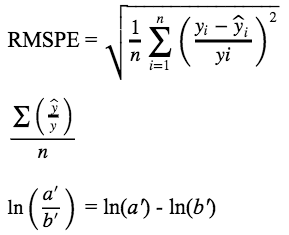

In [90]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)   # y_range to indicate that sales are between 0 and the max sale ever made.

NB: When we take the log of the data, getting the Root Mean Squared Error will get us the Root Mean Square Percentage Error.

## Create ModelData object

Very similar to the image recognition process
- find training dataset
- find test set
- set a learner
- fit and go (But since we are not doing images, but structured data: `ColumnarModelData`)
- PATH - where to store everything that you save later
- val_idx - which we will put in the validation set
- df - dataframe
- yl - target (dependent variable)
- cat_flds - which things we want to treat as categorical. At this time everything is a number

We can create a ModelData object directly from the data frame, passing it the test dataframe (df_test).
We must tell it which variables to treat as categorical (`cat_flds`)

In [91]:
from fastai.column_data import ColumnarModelData
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), 
                                       cat_flds=cat_vars, 
                                       bs=64, #bs=128,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. `Store`, in particular, has over a thousand!

In [92]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

Above is a list of every categorical variable and its cardinality.

NB: Even if there were no missing values in the original data, you should still set aside one for unknown just in case.

### Embeddings
We use the *cardinality* of each variable (number of unique values) to decide how large to make its *embeddings*. 
Each level will be associated with a vector with length defined as below.  
(We define the dimensionality of the embeddings).   
In NLP models it was found empirically that we need about 600, because human languages are complex. <br>
But for some categories there is very little need for so many, eg for a `StateHoliday`.
JH rule of thumb: look at how many discrete values the category has, 
and make the dimensionality of the embedding half of that, but not more than 50 (heuristic). 
```
(c, min(50, (c+1)//2))
```

(Ecuadorian competition may need bigger sizes of embeddings)

In [93]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz] #Heuristic for size of embedding
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

In [94]:
#??md.get_learner

### Get_learner and find Learning rate
0.04 is the dropout at the start, 
[1000, 500] are how many activation to start
[0.001,0.01] how much dropout in the later layers

In [95]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars), 
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [96]:
m.lr_find()

 53%|█████▎    | 8351/15894 [01:31<01:22, 91.08it/s, loss=0.948]

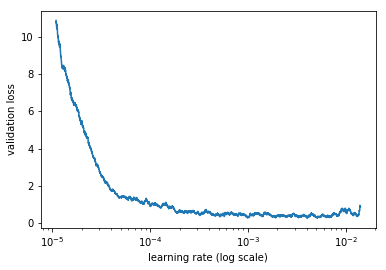

In [97]:
m.sched.plot(100) #100)

### Sample

In [98]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars), 
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

 `metrics`: this is a custom metric which specifies a function to be called at the end of every epoch and prints out a result

In [99]:
import math

In [100]:
%time m.fit(lr, 4, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.149705   0.0009     0.029561  
    1      0.137592   0.047091   0.242349                         
    2      0.12224    0.000463   0.021294                         
    3      0.084612   0.007302   0.089211                         
CPU times: user 11min 37s, sys: 10.6 s, total: 11min 47s
Wall time: 11min 36s


[0.00730238389223814, 0.08921146253662988]

In [101]:
%time m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.105896   0.000263   0.016365  
    1      0.090717   0.000598   0.024765                         
    2      0.057125   1e-05      0.003181                         
    3      0.072151   0.001048   0.031848                         
    4      0.054606   0.003173   0.054776                         
CPU times: user 14min 42s, sys: 12.6 s, total: 14min 54s
Wall time: 14min 40s


[0.0031734679359942675, 0.054776183666868435]

In [102]:
%time m.fit(lr, 4, metrics=[exp_rmspe], cycle_len=4)

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.034562   0.011435   0.112861  
    1      0.073348   0.0        0.000121                         
    2      0.074609   0.003141   0.057648                         
    3      0.062674   0.000981   0.031811                         
    4      0.090896   0.041111   0.224776                         
    5      0.060656   2.6e-05    0.005117                         
    6      0.078904   0.001145   0.034416                         
    7      0.037704   7e-06      0.00271                          
    8      0.044025   2.7e-05    0.005142                         
    9      0.041042   0.000337   0.018536                         
    10     0.024581   0.000228   0.0152                           
    11     0.023936   0.000877   0.029181                         
    12     0.063815   0.007616   0.09119                          
    13     0.031819   0.000101   0.010012                         
    14     0.04398

[0.0012568364618346095, 0.036087810354819144]

## All

In [103]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [104]:
m.fit(lr, 1, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.154767   0.004521   0.069552  


[0.004521185532212257, 0.06955190724074958]

In [105]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.112884   0.003701   0.06272   
    1      0.057635   0.007409   0.082475                         
    2      0.050344   0.00115    0.033337                         


[0.001149551011621952, 0.033336717758496955]

In [106]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.086404   0.007887   0.084981  
    1      0.053722   0.004423   0.064343                         
    2      0.089637   0.003737   0.059297                         


[0.003736591199412942, 0.059296891164714635]

### Test

In [107]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [108]:
%time m.fit(lr, 4, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.107745   0.001049   0.032911  
    1      0.10301    0.00798    0.093441                         
    2      0.112097   0.016998   0.139258                         
    3      0.104317   0.003874   0.064221                         
CPU times: user 11min 33s, sys: 10.2 s, total: 11min 43s
Wall time: 11min 32s


[0.003874248592182994, 0.06422135919180297]

In [ ]:
%time m.fit(lr, 4, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.084767   0.0003     0.017179  
    1      0.110815   0.000712   0.026324                         
 80%|███████▉  | 12661/15894 [02:20<00:35, 90.03it/s, loss=0.103] 

In [ ]:
m.save('val0')
m.load('val0')

In [ ]:
x,y=m.predict_with_targs()

In [ ]:
exp_rmspe(x,y)

In [ ]:
pred_test=m.predict(True)  #True to state this is the test set.  predict returns the logs of the predictions

pred_test = np.exp(pred_test)  #now get the actuals
#pred_test

In [ ]:
joined_test['Sales']=pred_test

In [ ]:
#joined_test['Sales']

In [ ]:
csv_fn=f'{PATH}tmp/sub.csv'

joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [ ]:
from IPython.lib.display import FileLink

FileLink(csv_fn)

# RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from fastai.dataset import split_by_idx

In [ ]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [ ]:
mr = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
mr.fit(trn, y_trn);

In [ ]:
preds = mr.predict(val)
mr.score(trn, y_trn), mr.score(val, y_val), mr.oob_score_, exp_rmspe(preds, y_val)

```
np.exp(preds)
trn
#forest_test = np.
#forest_test['Sales']=np.exp(preds)
#forest_test
```

# END

In [ ]:
t1 = time.clock()
time.ctime(time.time()), (t1 - t0)

In [ ]:
#train.StateHoliday = train.StateHoliday != "0"